# Домашнее задание 5. Градиентный спуск. 

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

In [647]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [648]:
import abc

class BaseLoss(abc.ABC):
    """Базовый класс лосса"""
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1:** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [649]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        loss = np.linalg.norm(np.dot(X,w) - y)**2/X.shape[0]
        return loss
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        grad = 2 / X.shape[0] * np.dot(X.T,(np.dot(X,w)-y))
        return grad

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [650]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483., 
                                                      1199584., 1208685., 1217786., 1226887., 
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 :** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [651]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 100000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    w_list = [w_init]
    w = w_init
    for i in range(n_iterations):
        w_curr = w
        w = w_curr - lr * loss.calc_grad(X, y, w_curr)
        if np.linalg.norm(w - w_curr) <= 1e-5:
            break
        w_list.append(w)
    return w_list

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [652]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [653]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045026
0.8670644652632045


In [654]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 :** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`)

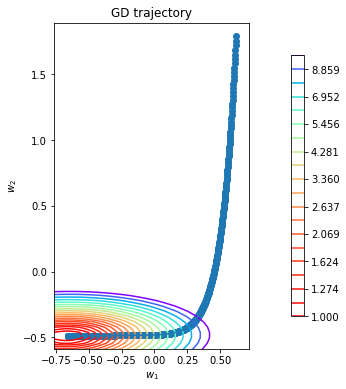

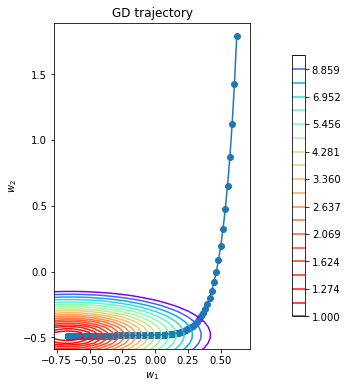

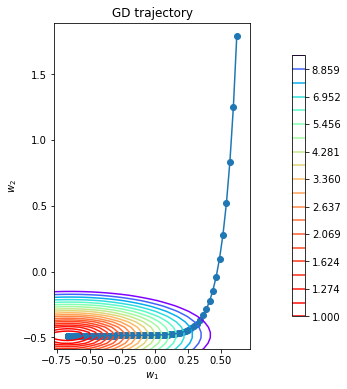

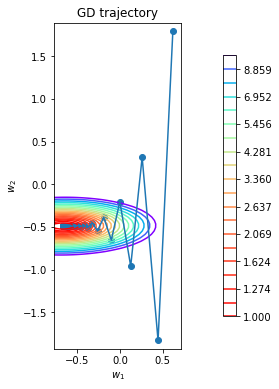

In [655]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.0001)
plot_gd(w_list, X, y, loss)
w_list = gradient_descent(w_init, X, y, loss, 0.001)
plot_gd(w_list, X, y, loss)
w_list = gradient_descent(w_init, X, y, loss, 0.0015)
plot_gd(w_list, X, y, loss)
w_list = gradient_descent(w_init, X, y, loss, 0.01)
plot_gd(w_list, X, y, loss)

Чем больше lr, тем быстрее сходится градиентный спуск

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 :** Реализуйте функцию `stochastic_gradient_descent`


```

In [656]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch = X[batch_indices]
    y = y[batch_indices]
    w = np.copy(w_init)
    w_list = []
    w_list.append(w)
    for i in range(1,n_iterations):
        w_list.append( w_list[i-1] - lr * loss.calc_grad(batch, y , w_list[i-1]))
        if np.linalg.norm(w_list[i] -w_list[i-1] ) <= 1e-5:
            break
    return w_list

**Задание 1.5 :** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). 

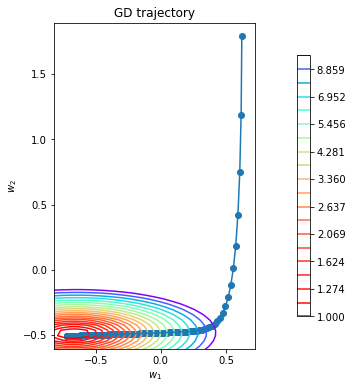

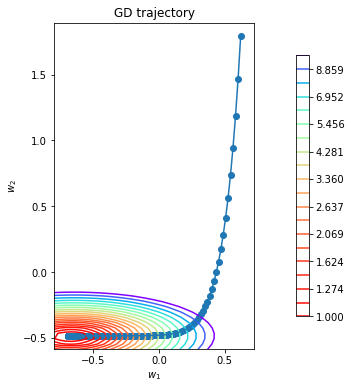

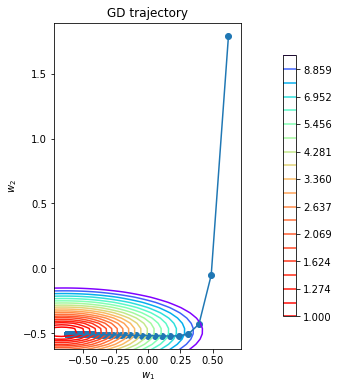

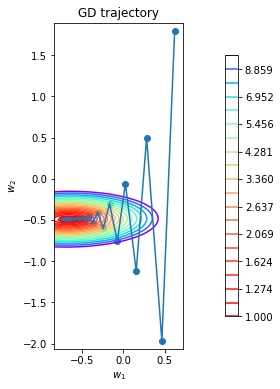

In [659]:
loss = MSELoss()
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.0015, 40)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 40)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.005, 40)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 40)
plot_gd(w_list, X, y, loss)


Чем больше lr, тем быстрее достигается минимум

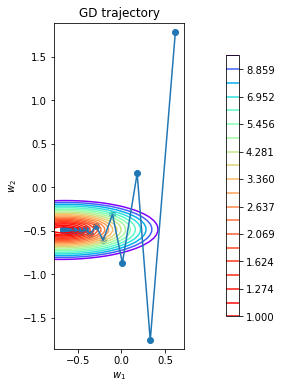

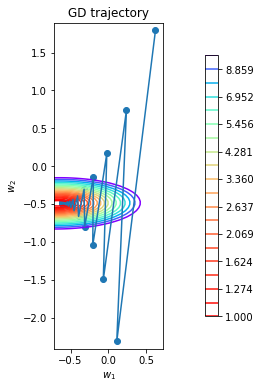

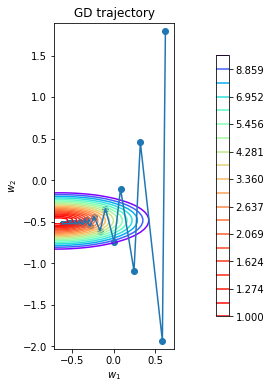

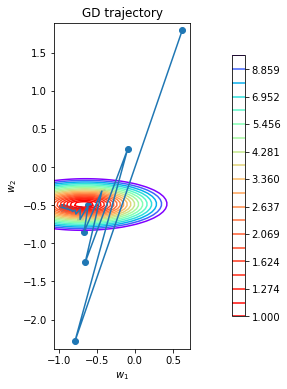

In [661]:
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 100)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 50)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 3)
plot_gd(w_list, X, y, loss)

Чем больше batch_size, тем меньшее количество операций необходимо чтобы дойти до минимума. Если батч слишком маленький спуск может не достичь минимума

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [663]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch = X[batch_indices]
    y = y[batch_indices]
    w = np.copy(w_init)
    w_list = []
    w_list.append(w)
    for i in range(1,n_iterations):
        w_list.append( w_list[i-1] - lr*((1/(1+i))**p) * loss.calc_grad(batch, y , w_list[i-1]))
        if abs(np.linalg.norm(loss.calc_grad(batch, y , w_list[i]))) <= 1e-5:
            break
    return w_list

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. 



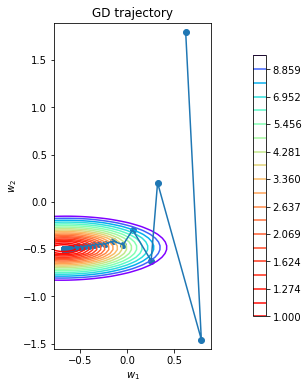

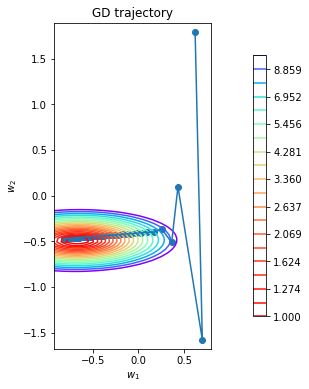

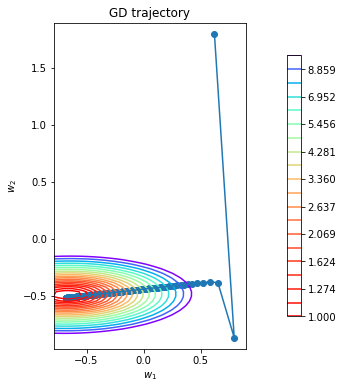

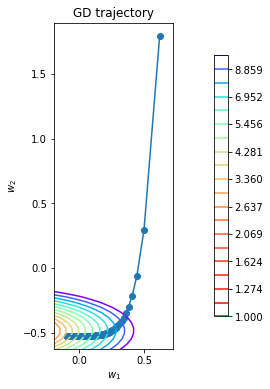

In [664]:
loss = MSELoss()
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01,10,0.1)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01,10,0.3)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01,10,0.6)
plot_gd(w_list, X, y, loss)
w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01,10,1)
plot_gd(w_list, X, y, loss)

Чем больше p, тем меньше шагов проходит спуск, но если взять его слишком большим, то спуск может не достигнуть минимума

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

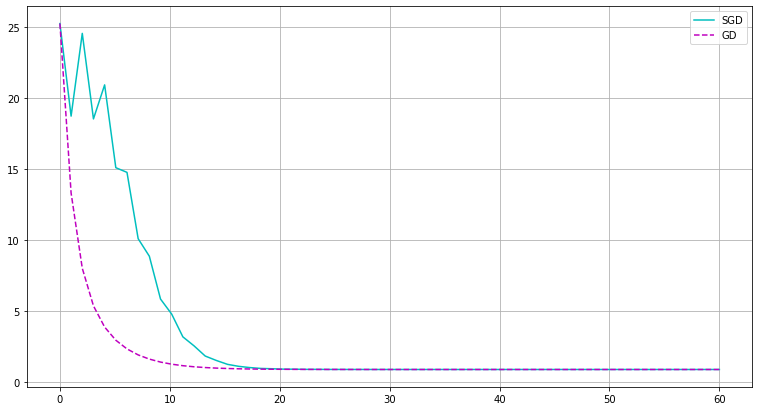

In [666]:
w_init = np.random.uniform(-2, 2, (n_features))
loss = MSELoss()
w_list_SGD = stochastic_gradient_descent(w_init, X, y, loss, 0.01,10,0.1)
w_list_GD = gradient_descent(w_init, X, y, loss, 0.01)
loss_SGD = []
loss_GD = []
for i in range(len(w_list_GD)):
    loss_SGD.append(loss.calc_loss(X,y,w_list_SGD[i]))
    loss_GD.append(loss.calc_loss(X,y,w_list_GD[i]))
    
plt.figure(figsize=(13, 7))
plt.plot(np.linspace(0,len(loss_SGD),len(loss_SGD)) ,loss_SGD,color='c' ,label="SGD")
plt.plot(np.linspace(0,len(loss_GD),len(loss_GD)),loss_GD,color='m',linestyle="--", label="GD")
plt.legend()
plt.grid(True)

Стохастический градиентный спуск работает быстрее, чем обычный градиентный спуск, но также он более хаотичный, и есть вероятность, что он не найдет минимум функции потерь. 

## Часть 2. Линейная регрессия 

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

In [673]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        w_init = np.ones(X.shape[1])
        w_list = gradient_descent(w_init,X, y, self.loss,self.lr)
        self.w = w_list[-1]

        
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        y = np.dot(X,self.w)
        return y

In [698]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [699]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", 
    header=None, 
    na_values=["?"]
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [700]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

**Задание 2.2 :** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [701]:
X_raw.head(5)

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22


In [702]:
print('Количество пропусков по столбцам')
X_raw.isna().sum()

Количество пропусков по столбцам


index     0
0         0
1        37
2         0
3         0
4         0
5         2
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        4
19        4
20        0
21        2
22        2
23        0
24        0
dtype: int64

In [703]:
# заполним пропуски 
X_raw[1] = X_raw[1].fillna(X_raw[1].mean())
X_raw[5] = X_raw[1].fillna('Unknown')
X_raw[18] = X_raw[18].fillna(X_raw[18].mean())
X_raw[19] = X_raw[19].fillna(X_raw[19].mean())
X_raw[21] = X_raw[21].fillna(X_raw[21].mean())
X_raw[22] = X_raw[22].fillna(X_raw[22].mean())
print('Количество пропусков по столбцам')
X_raw.isna().sum()

Количество пропусков по столбцам


index    0
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
dtype: int64

In [704]:
# Проведем One-hot кодирование и нормализуем вещественные данные
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


X_raw_1 = pd.get_dummies(X_raw[[2,3,4,6,7,8,14,15,17]])
X_raw.drop(['index',2,3,4,6,7,8,14,15,17],axis = 1,inplace=True)

scaler.fit(X_raw)
X_raw = pd.DataFrame(scaler.transform(X_raw))


X_raw = X_raw.merge(X_raw_1,left_index=True,right_index=True) 

In [705]:
# разделим выборку
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=22)

**Задание 2.3:** Обучите написанную вами линейную регрессию на обучающей выборке

In [706]:
linear_regression.fit(x_train,y_train)
y_pred_train = linear_regression.predict(x_train)
y_pred_test = linear_regression.predict(x_test) 

**Задание 2.4 :** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [707]:
from sklearn.metrics import mean_squared_error
print("Train: ",mean_squared_error(y_train,y_pred_train))
print("Test: ",mean_squared_error(y_test,y_pred_test))

Train:  41852016.07798191
Test:  84409739.24471566


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 :** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

In [708]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        Xw = np.dot(X,w)
        loss = (1/X.shape[0]) * (np.linalg.norm(Xw- y)**2) + self.coef * (np.linalg.norm(w[:-1]) **2)
        return loss
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        
        Xw = np.dot(X,w)
        w[-1] = 0
        grad = (2/X.shape[0]) * (X.T.dot(Xw - y)) + 2 * self.coef * w
        return grad 

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [709]:
linear_regression = LinearRegression(MSEL2Loss(0.4))

**Задание 2.6 :** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [710]:
linear_regression.fit(x_train,y_train)
y_pred_train = linear_regression.predict(x_train)
y_pred_test = linear_regression.predict(x_test) 

In [712]:
print("Train: ",mean_squared_error(y_train,y_pred_train))
print("Test: ",mean_squared_error(y_test,y_pred_test))

Train:  65192913.5025692
Test:  47269455.70007773


Как мы видим ошибка уменьшилась на обоих выбросах и наша модель теперь не переобучается 

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 :** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [717]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        
        z = X.dot(w) - y
        if np.linalg.norm(z) < abs(self.eps):
            return np.linalg.norm((1/2) * (z))/X.shape[0]
        else: 
            return self.eps*(np.linalg.norm(z)-(1/2)*self.eps)
                
            
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        z = X.dot(w) - y
        if np.linalg.norm(z) < abs(self.eps):
            return np.dot(X,z)/X.shape[0]
        else: 
            return np.dot(X.T,self.eps*(np.sign(z)))/X.shape[0]
        
        
#         return grad

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [718]:
linear_regression = LinearRegression(HuberLoss(1.35))

In [719]:
linear_regression.fit(X_train,y_train)
y_pred_train = linear_regression.predict(X_train)
y_pred_test = linear_regression.predict(X_test) 

In [721]:
print("Train: ",mean_squared_error(y_train,y_pred_train))
print("Test: ",mean_squared_error(y_test,y_pred_test))

Train:  13793439.277050182
Test:  8991080.507978136


Так как HuberLoss меньше реагирует на выбросы, то ошибка стала гораздо меньше, чем при обученни с MSELoss, как на тестовой, так и на обучающей выборках